<a href="https://colab.research.google.com/github/furibeguerra/procesamiento_lenguaje_natural_2025B3/blob/main/Desafio_4_Uribe_Guerra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio 4 - Fabian Andres Uribe Guerra

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import re
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Activation, Flatten,
    LSTM, SimpleRNN, Embedding
)
from sklearn.model_selection import train_test_split


In [3]:
import requests

url = "https://convai.io/data/data_tolokers.json"
response = requests.get(url)

with open("data_tolokers.json", "wb") as f:
    f.write(response.content)

In [4]:
# dataset_file
import json

text_file = "data_tolokers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [5]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [6]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt = txt.replace("'d", " had")
    txt = txt.replace("'s", " is")
    txt = txt.replace("'m", " am")
    txt = txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    return txt.strip()

for line in data:
    for i in range(len(line['dialog']) - 1):
        input_text = clean_text(line['dialog'][i]['text'])
        output_text = clean_text(line['dialog'][i + 1]['text'])

        if len(input_text) >= max_len or len(output_text) >= max_len:
            continue

        # Agregar tokens especiales
        output_sentence = output_text + ' <eos>'
        output_sentence_input = '<sos> ' + output_text

        input_sentences.append(input_text)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 12712


In [10]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]


('hey', 'what do you do <eos>', '<sos> what do you do')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

#### Obtener word2idx_inputs, max_input_len

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [17]:
MAX_VOCAB_SIZE = 10000

In [18]:
# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 2439
Sentencia de entrada más larga: 10


#### word2idx_outputs, max_out_len, num_words_output

In [19]:
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 2510
Sentencia de salida más larga: 11


#### encoder_input_sequences, decoder_output_sequences, decoder_targets

In [22]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 12712
encoder_input_sequences shape: (12712, 10)
decoder_input_sequences shape: (12712, 11)


In [23]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(12712, 11, 2511)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [24]:
import gdown
import os
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download' #gloveembedding.pkl (501M)
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From (original): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download
From (redirected): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t&uuid=fae073a2-d593-4f56-84ae-e4c66d7f1d41
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:06<00:00, 76.0MB/s]


In [25]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gunzip cc.en.300.vec.gz


--2025-08-24 18:19:26--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.108, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G   138MB/s    in 6.2s    

2025-08-24 18:19:32 (203 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [26]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [27]:
model_embeddings = FasttextEmbeddings()

In [28]:
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

number of null word embeddings: 1


### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [29]:
max_input_len

10

In [30]:
n_units = 256

# define training encoder
encoder_inputs = Input(shape=(max_input_len,), name='encoder_input')  #tupla de un solo elemento

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True, dropout=0.2, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,), name='decoder_input')
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_embedded  = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_embedded , initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 10, 300)   │    731,700 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 11, 256)   │    642,816 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    570,368 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 11, 256), │    525,312 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 11, 2511)  │    645,327 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,115,523 (11.88 MB)

 Trainable params: 2,383,823 (9.09 MB)

 Non-trainable params: 731,700 (2.79 MB)

In [31]:
from tensorflow.keras.utils import plot_model


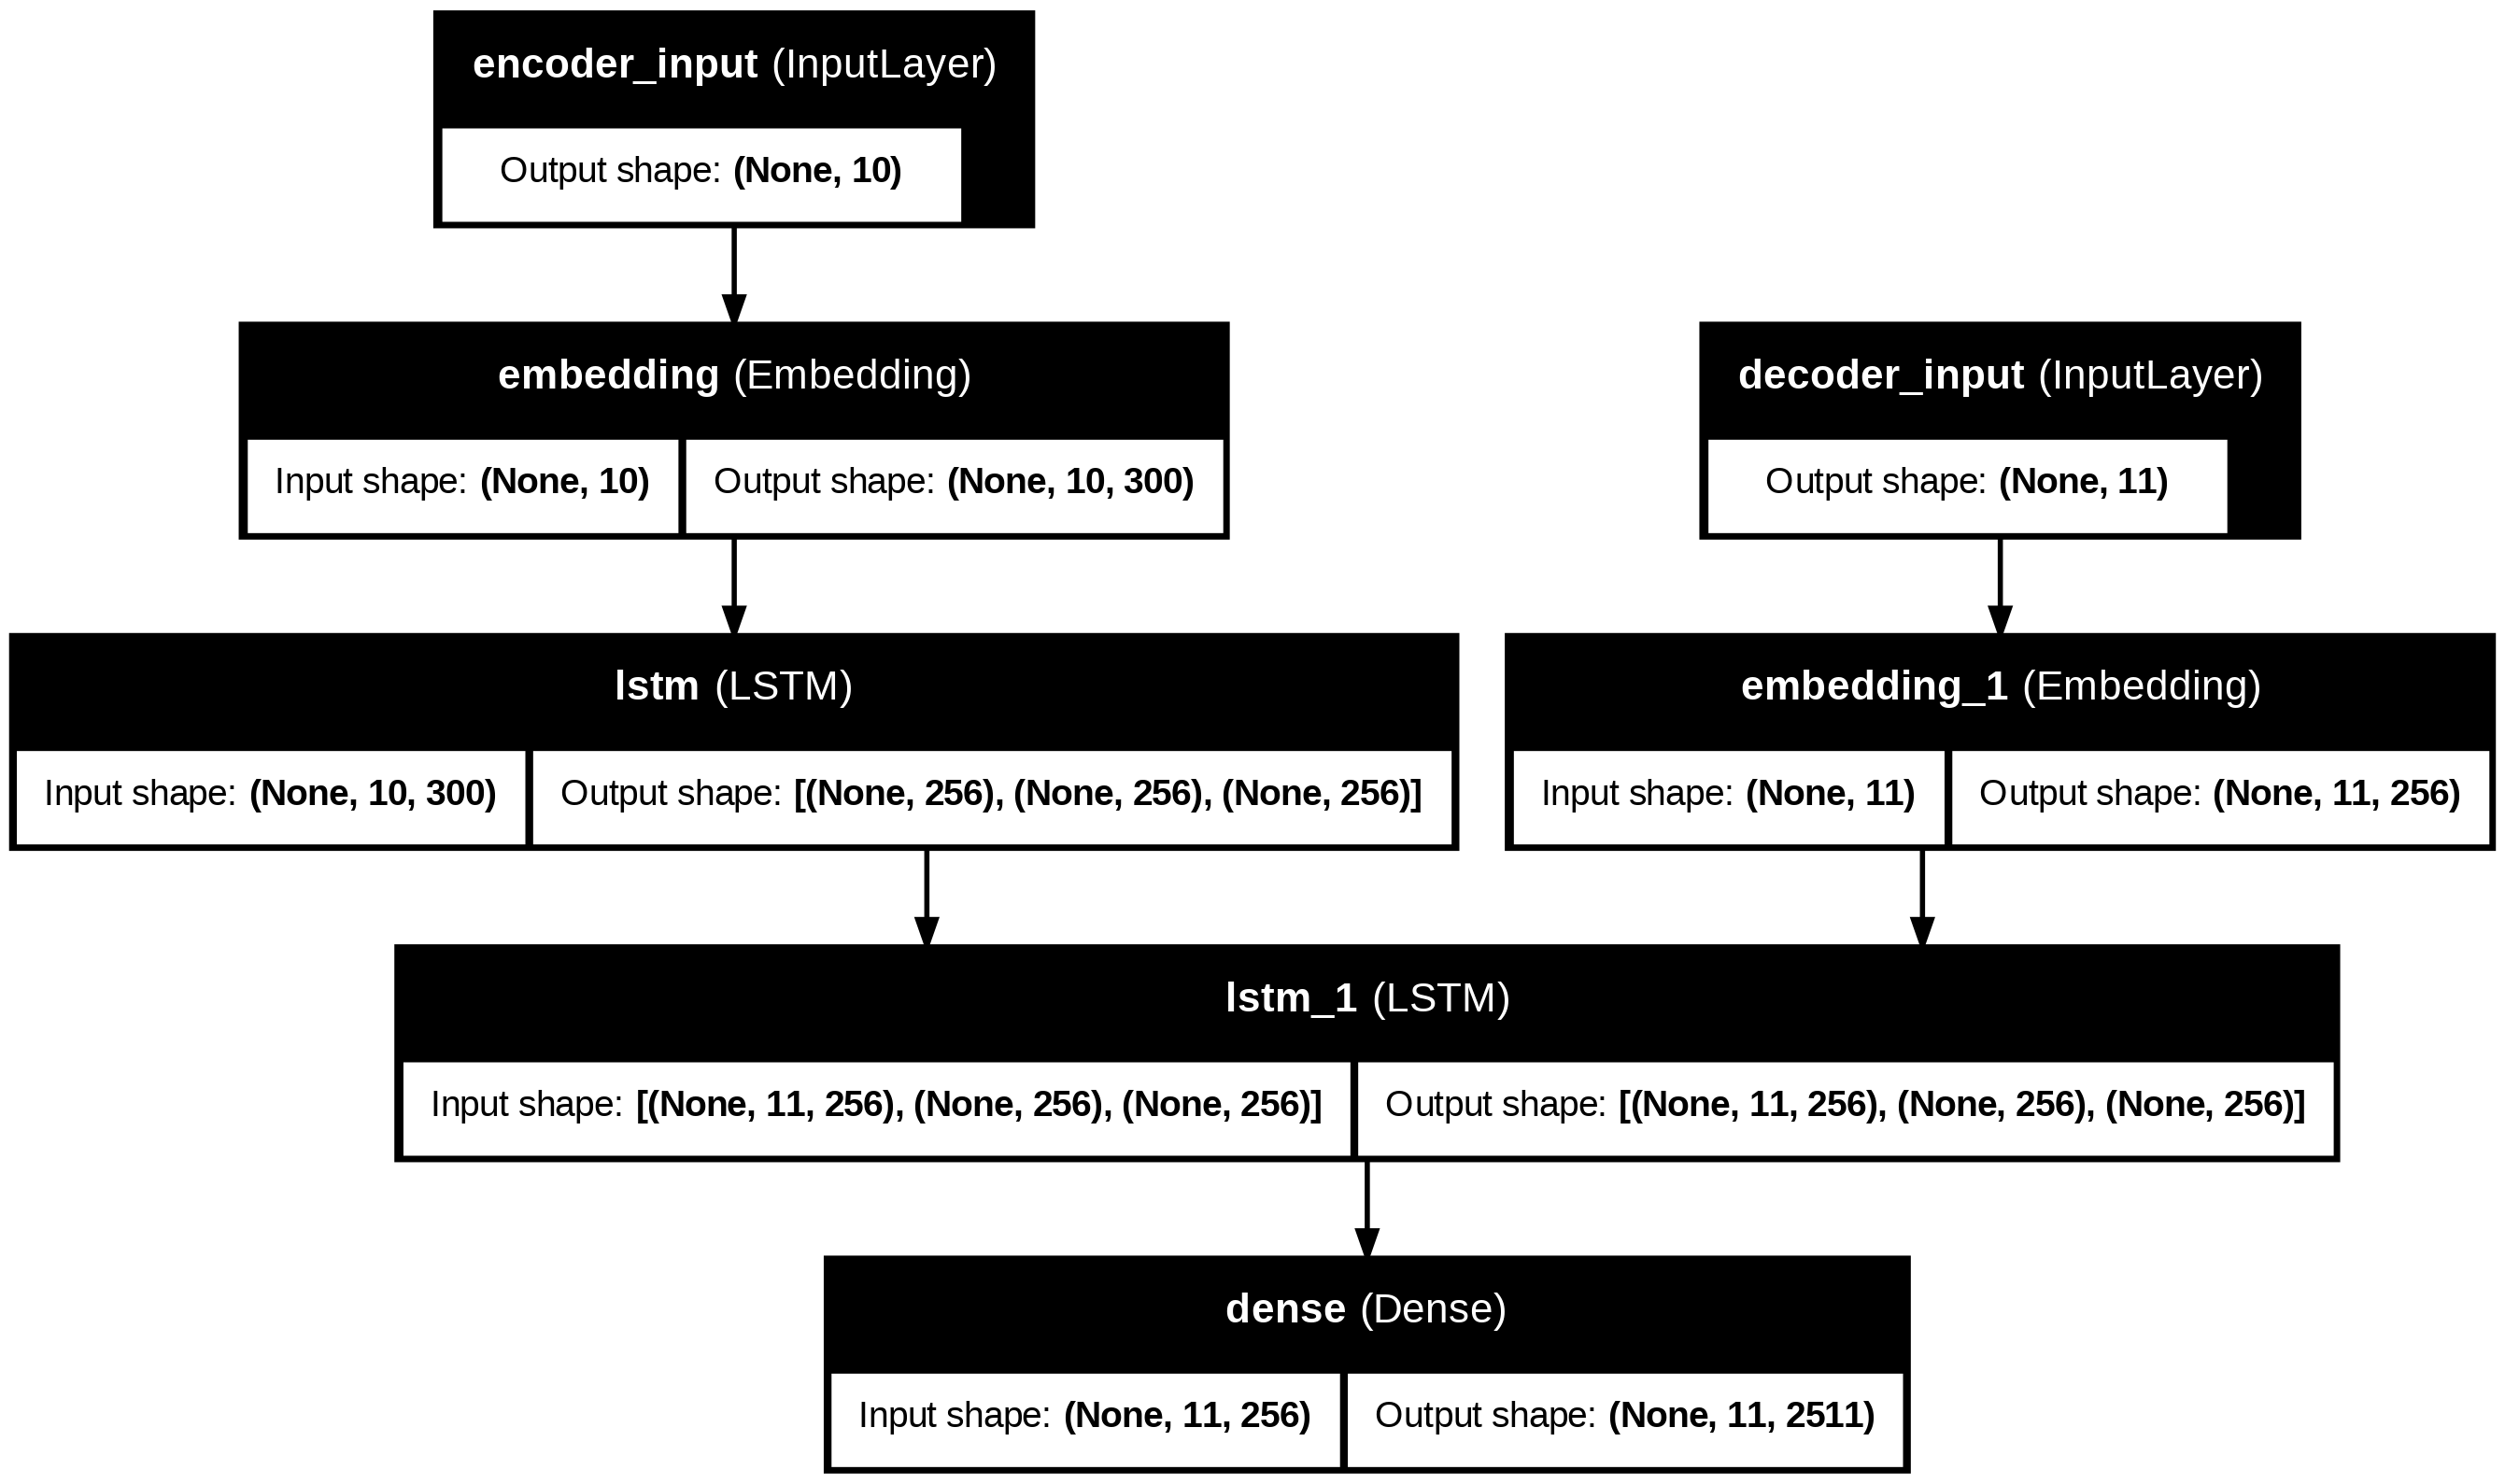

In [32]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

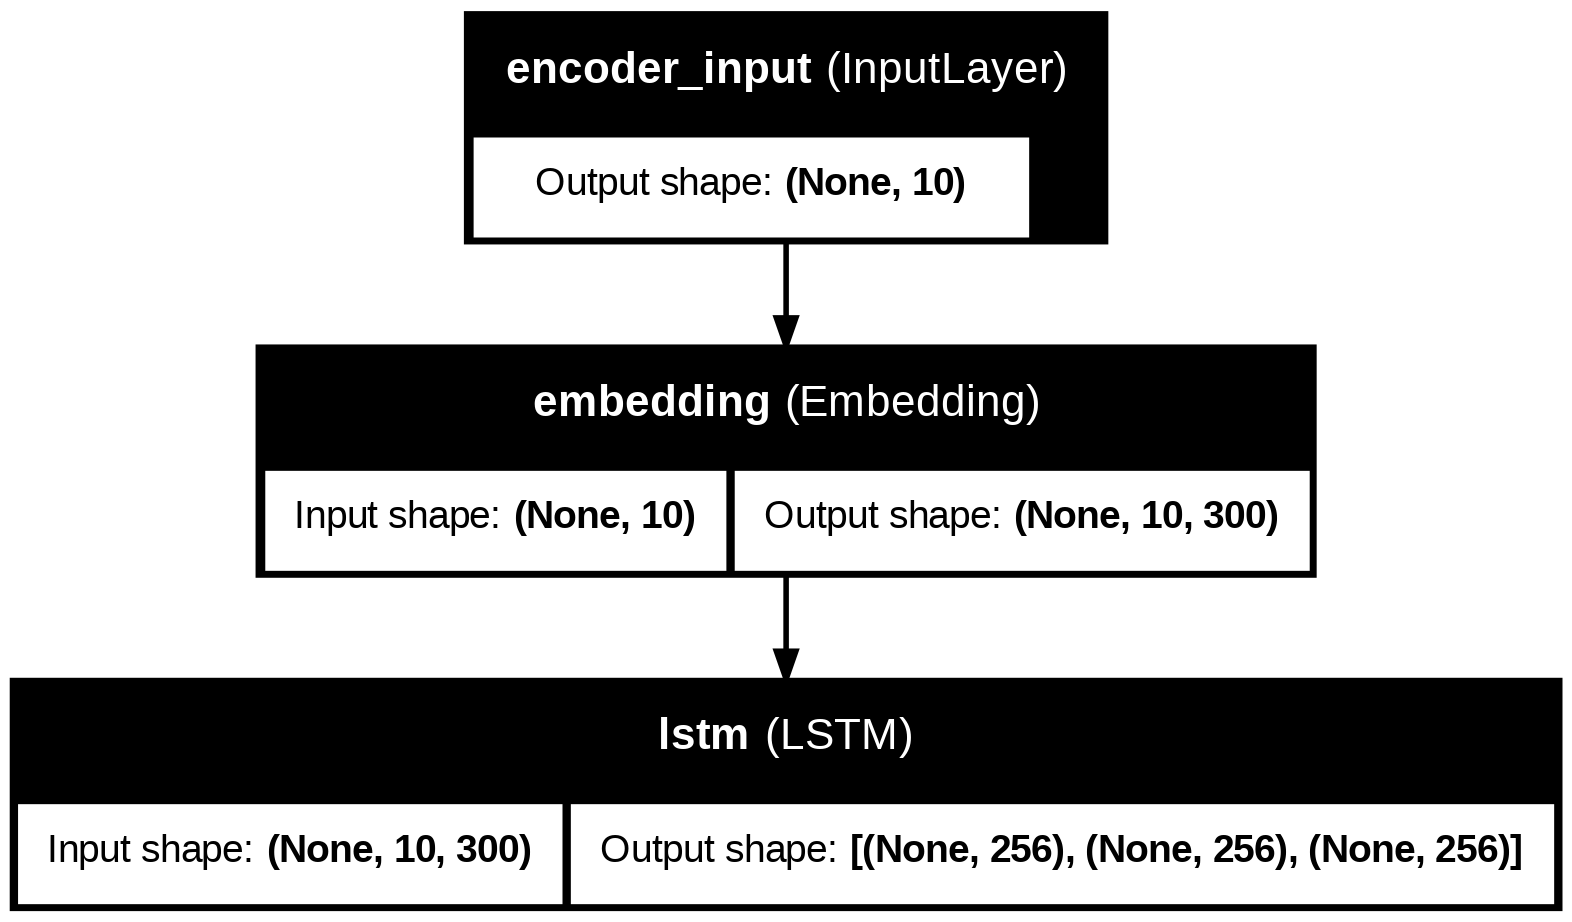

In [33]:
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

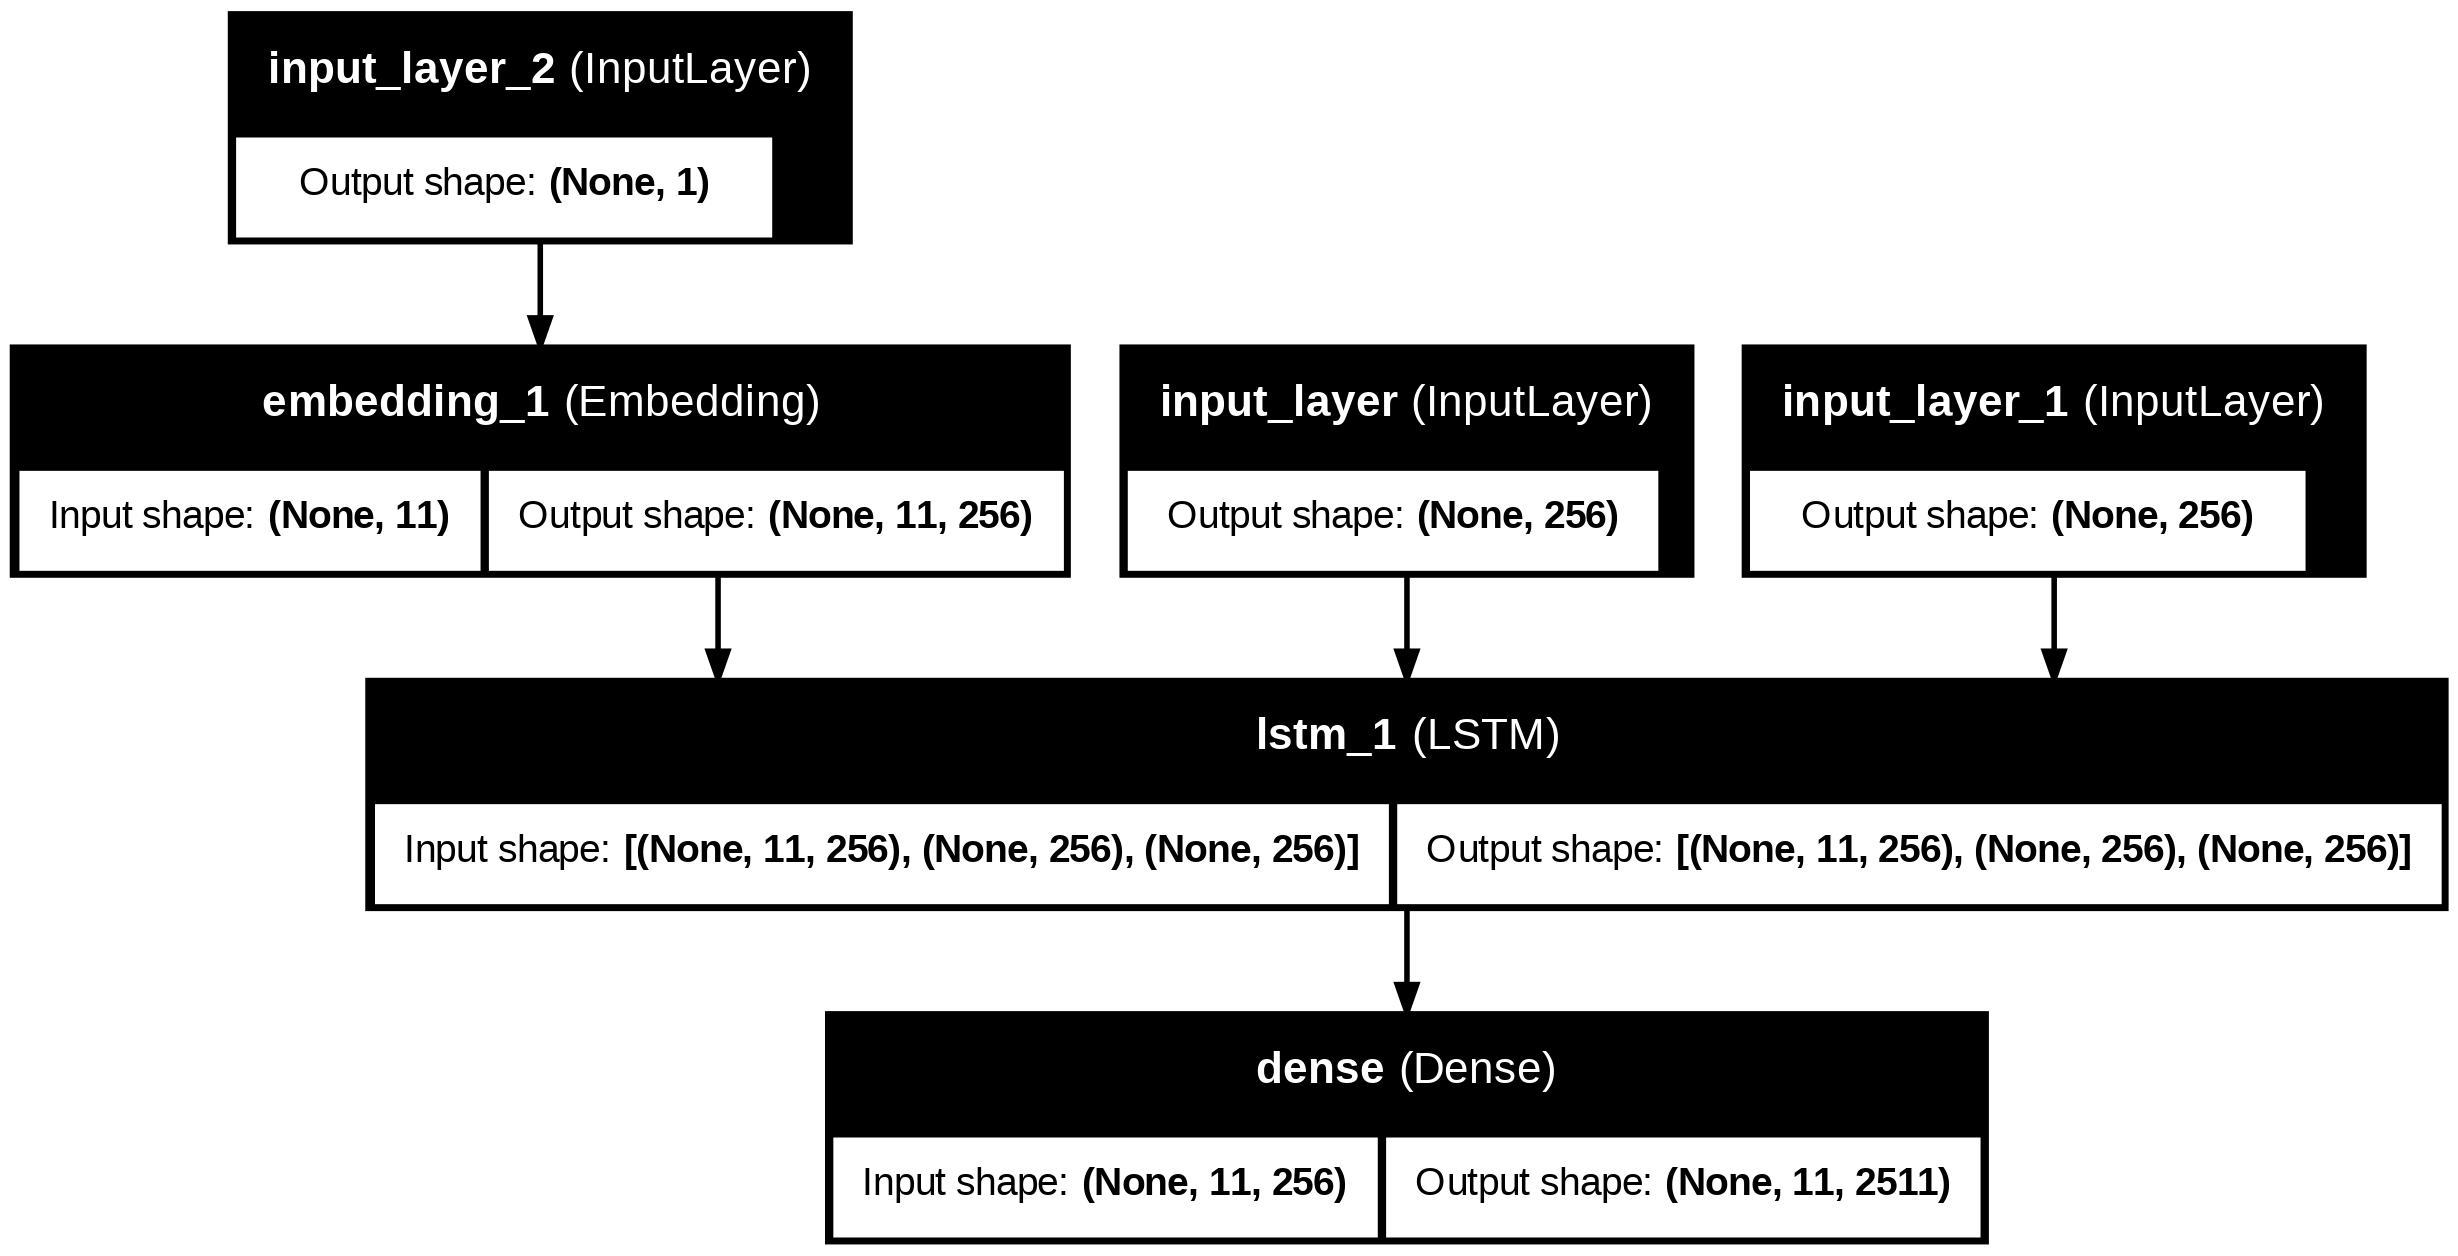

In [34]:
# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [35]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50,
    validation_split=0.2)

Epoch 1/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - accuracy: 0.6067 - loss: 2.8723 - val_accuracy: 0.6943 - val_loss: 1.8137
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 31s 96ms/step - accuracy: 0.7151 - loss: 1.6200 - val_accuracy: 0.7180 - val_loss: 1.6267
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - accuracy: 0.7319 - loss: 1.4457 - val_accuracy: 0.7269 - val_loss: 1.5370
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.7443 - loss: 1.3319 - val_accuracy: 0.7379 - val_loss: 1.4798
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step - accuracy: 0.7526 - loss: 1.2607 - val_accuracy: 0.7429 - val_loss: 1.4443
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - accuracy: 0.7605 - loss: 1.1842 - val_accuracy: 0.7444 - val_loss: 1.4221
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 41s 94ms/step - accuracy: 0.7654 - loss: 1.1380 - val_accuracy: 0.7469 - val_loss: 1.4070
Epoch 8/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 40s 91ms/step - accuracy: 0.7679 - loss: 1.0971 - 

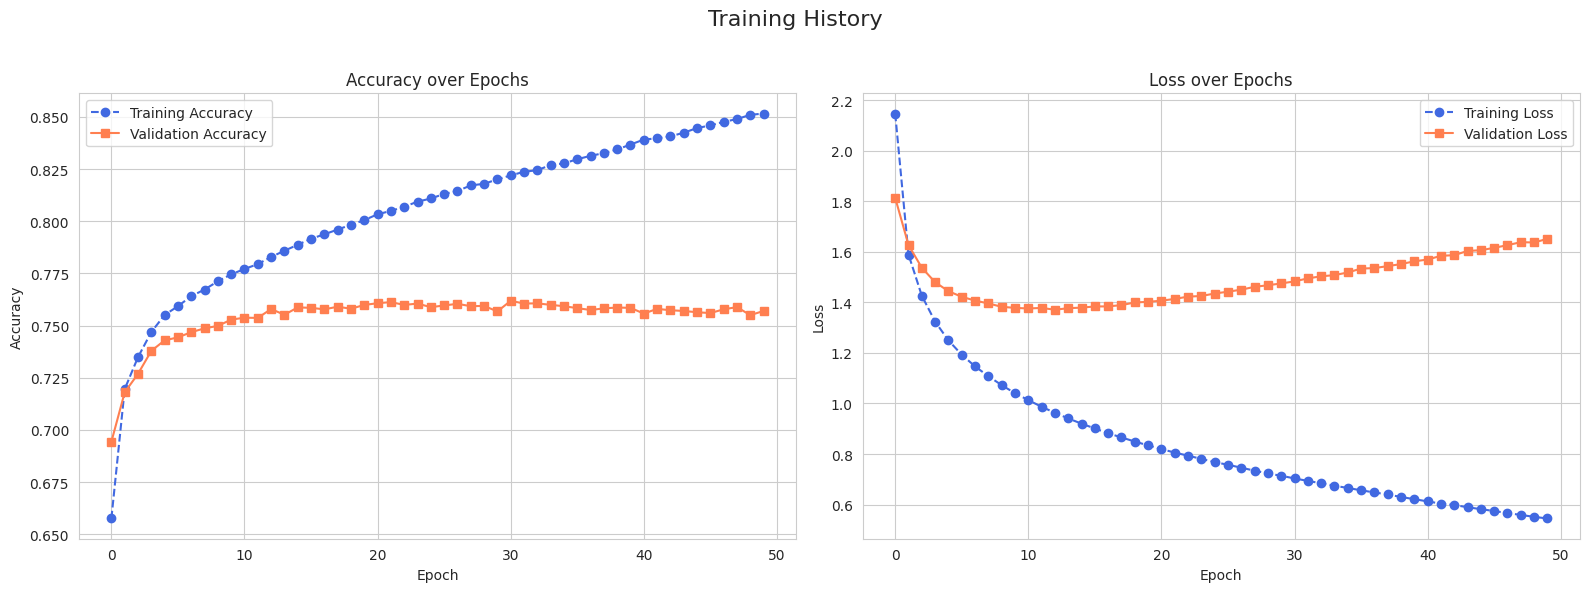

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(history, title='Training History'):
    """
    Plots the training and validation accuracy/loss from a Keras history object.

    Args:
        history (dict): The history object returned by model.fit().
        title (str): The title for the plot.
    """

    # Check if 'history' is a valid dictionary
    if not isinstance(history, dict):
        if hasattr(history, 'history'):
            history = history.history
        else:
            print("Error: The 'history' object must be a dictionary or a Keras History object.")
            return

    # Set a custom style for better aesthetics
    sns.set_style("whitegrid")

    # Create the figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(title, fontsize=16)

    # Plot Accuracy
    ax1.plot(history['accuracy'], label='Training Accuracy', color='royalblue', marker='o', linestyle='--')
    ax1.plot(history['val_accuracy'], label='Validation Accuracy', color='coral', marker='s', linestyle='-')
    ax1.set_title('Accuracy over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot Loss
    if 'loss' in history and 'val_loss' in history:
        ax2.plot(history['loss'], label='Training Loss', color='royalblue', marker='o', linestyle='--')
        ax2.plot(history['val_loss'], label='Validation Loss', color='coral', marker='s', linestyle='-')
        ax2.set_title('Loss over Epochs')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
    else:
        fig.delaxes(ax2) # Remove the second subplot if loss data is not available
        print("Warning: Loss data not found in history.")

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
    plt.show()


plot_training_history(hist)

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [38]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [49]:
def generate_answer(input_seq):
    # La primera predicción del encoder
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Inicializar el decoder con <sos>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    eos = word2idx_outputs['<eos>']
    output_sentence = []

    # Generar tokens de la respuesta, uno por uno
    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        idx = np.argmax(output_tokens[0, 0, :])

        # Fin de la respuesta
        if idx == eos:
            break

        # Convertir idx a palabra (solo si es válida)
        if idx > 0:
            word = idx2word_target.get(idx, '')
            output_sentence.append(word)

        # Actualizar entrada al decoder y estados
        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)


In [50]:
i = 500
input_seq = encoder_input_sequences[i:i+1]

print("🧾 Pregunta:", input_sentences[i])
print("✅ Respuesta real:", output_sentences[i])
print("🤖 Respuesta generada:", generate_answer(input_seq))


🧾 Pregunta: six may i have them
✅ Respuesta real: no you may not <eos>
🤖 Respuesta generada: i am a teacher what about you


In [45]:
def test_custom_question(question: str) -> str:
    """
    Prueba el modelo encoder-decoder con una pregunta custom.

    Parámetros:
        question (str): La pregunta en texto.

    Retorna:
        str: La respuesta generada por el modelo.
    """
    tokens = question.lower().split()
    unk_token = word2idx_inputs.get('<unk>', 0)
    sequence = [word2idx_inputs.get(token, unk_token) for token in tokens]
    sequence_padded = pad_sequences([sequence], maxlen=max_input_len, padding='pre')
    answer = generate_answer(sequence_padded)
    return answer

In [51]:
custom_question = "are you dead?"
response = test_custom_question(custom_question)
print("🤔 Pregunta:", custom_question)
print("🤖 Respuesta generada:", response)

🤔 Pregunta: are you dead?
🤖 Respuesta generada: i am not i am a real man


In [52]:
custom_question = "Do you have any pet?"
response = test_custom_question(custom_question)
print("🤔 Pregunta:", custom_question)
print("🤖 Respuesta generada:", response)

🤔 Pregunta: Do you have any pet?
🤖 Respuesta generada: i do not i have a dog


In [53]:
custom_question = "Where are you from?"
response = test_custom_question(custom_question)
print("🤔 Pregunta:", custom_question)
print("🤖 Respuesta generada:", response)

❓ Pregunta: Where are you from?
🤖 Respuesta generada: i am from the united states


In [55]:
custom_question = "how old are you?"
response = test_custom_question(custom_question)
print("🤔 Pregunta:", custom_question)
print("🤖 Respuesta generada:", response)

❓ Pregunta: how old are you?
🤖 Respuesta generada: i am not sure


In [56]:
custom_question = "What's your name?"
response = test_custom_question(custom_question)
print("🤔 Pregunta:", custom_question)
print("🤖 Respuesta generada:", response)

❓ Pregunta: What's your name?
🤖 Respuesta generada: i am not sure what that means


In [57]:
custom_question = "What's your favorite country?"
response = test_custom_question(custom_question)
print("🤔 Pregunta:", custom_question)
print("🤖 Respuesta generada:", response)

🤔 Pregunta: What's your favorite country?
🤖 Respuesta generada: i do not know what that is


In [58]:
#Quise testear una conversacion como si fuera con ChatGPT, lo limitaremos a 5 consultas
for i in range(5):
    custom_question = input("🤔 Haz una pregunta en ingles (o escribe 'salir' para terminar): ")
    if custom_question.lower() == 'salir':
        print("🤖 ¡Hasta luego!")
        break
    response = test_custom_question(custom_question)
    print("🤖 Respuesta generada:", response)
    print("-" * 20)

🤔 Haz una pregunta (o escribe 'salir' para terminar): what's your favourite book
🤖 Respuesta generada: i do not have any hobbies
--------------------
🤔 Haz una pregunta (o escribe 'salir' para terminar): Why?
🤖 Respuesta generada: i like to play hockey
--------------------
🤔 Haz una pregunta (o escribe 'salir' para terminar): That's a hobbit
🤖 Respuesta generada: i am not gon na let you go
--------------------
🤔 Haz una pregunta (o escribe 'salir' para terminar): Are u crazy?
🤖 Respuesta generada: i am not a fan of that
--------------------
🤔 Haz una pregunta (o escribe 'salir' para terminar): Do you like to read?
🤖 Respuesta generada: i do not i am a vegan
--------------------


Debido a que es un bucle For cada pregunta resulta independiente de la otra, por lo que tener una conversación fluida requeriria modificar parte del codigo para generar contexto. Aquí nos enfrentamos al problema clasificado como "ventana de contexto limitada". Lo cual no se desarrollara en este desafio ya que no hace parte del mismo.

Dejando de lado lo anterior, nuestro modelo respondio algunas preguntas coherentemente mientras que en otras no tenia sentido lo que decia. Sin embargo, se ha cumplido con el proposito del desafio al entrenar el Bot QA.